# CS-E-106: Data Modeling
## Fall 2019: HW 07

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics import gofplots
import pylab


**Question 1:** Refer to the CDI data set. A regression model relating serious crime rate (Y, total serious crimes divided by total population) to population density (X1, total population divided by land area) and unemployment rate (X3) is to be constructed. (15 pts)

**(a)** Fit second-order regression model (equation 8.8 on the book). Plot the residuals against the fitted values. How well does the second-order model appear to fit the data? What is R2? (5pts)

**Solution:**

In [8]:
cdi_data = pd.read_csv("data/CDI.csv")

df_1 = cdi_data

Y = df_1["Total serious crimes"]/df_1["Total population"]
X1 = df_1["Total population"]/df_1["Land area"]
X3 = df_1["Percent unemployment"]

df_1["x1"] = (X1-np.mean(X1))/np.std(X1)
df_1["x3"] = (X3-np.mean(X3))/np.std(X3)
df_1["x1sqr"] = df_1["x1"]**2
df_1["x3sqr"] = df_1["x3"]**2
df_1["x1x3"] = df_1["x1"]*df_1["x3"]

In [10]:
lm_cdi_1a = ols("Y~x1+x3+x1sqr+x3sqr+x1x3", data=df_1).fit()
lm_cdi_1a.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.240     
Dependent Variable: Y                AIC:                -2033.8930
Date:               2019-11-17 23:49 BIC:                -2009.3723
No. Observations:   440              Log-Likelihood:     1022.9    
Df Model:           5                F-statistic:        28.70     
Df Residuals:       434              Prob (F-statistic): 3.69e-25  
R-squared:          0.248            Scale:              0.00056771
---------------------------------------------------------------------
              Coef.    Std.Err.      t      P>|t|     [0.025   0.975]
---------------------------------------------------------------------
Intercept     0.0563     0.0013   44.6625   0.0000    0.0538   0.0588
x1            0.0101     0.0022    4.6589   0.0000    0.0058   0.0143
x3           -0.0002     0.0015   -0.1402   0.8886   -0.0031   0.0027
x1sqr         0.0000     0.0003    0.0455   0.9637   -0.0005   0.0006
x3sqr         0.0009     0.0005    1.7076   0.0884   -0.0001   0.0019
x1x3          0.0043     0.0021    2.0368   0.0423    0.0001   0.0084
-------------------------------------------------------------------
Omnibus:              22.989        Durbin-Watson:           1.787 
Prob(Omnibus):        0.000         Jarque-Bera (JB):        25.127
Skew:                 0.571         Prob(JB):                0.000 
Kurtosis:             3.260         Condition No.:           21    
===================================================================

"""

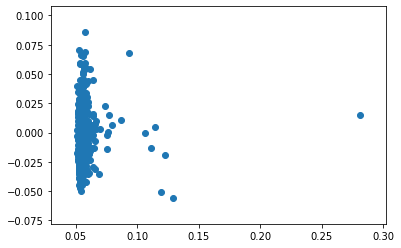

In [12]:
ei = lm_cdi_1a.resid
fitted_values = lm_cdi_1a.fittedvalues
plt.scatter(fitted_values,ei)

In [16]:
coeffs = lm_cdi_1a.params
coeffs

Intercept    0.056288
x1           0.010052
x3          -0.000205
x1sqr        0.000013
x3sqr        0.000889
x1x3         0.004266
dtype: float64

In [21]:
print("The regression model is Yhat = %s + %s*x1 + %s*x3 + %s*x1sqr + %s*x3sqr + %s*x1x3" %(coeffs["Intercept"], coeffs["x1"], coeffs["x3"], coeffs["x1sqr"], coeffs["x3sqr"], coeffs["x1x3"]))

The regression model is Yhat = 0.05628803374324597 + 0.01005156005150148*x1 + -0.0002054996301641967*x3 + 1.2966975612571088e-05*x1sqr + 0.0008885208310572405*x3sqr + 0.004266375165763692*x1x3


In [24]:
print("R-squared = %s"%lm_cdi_1a.rsquared)

R-squared = 0.24847487775386223


We can see that the regression model is not a very great fit based on the $R^2$ and the residual plot (we can see outliers and non-constant variance in the error terms).

**(b)** 

Test whether or not all quadratic and interaction terms can be dropped from the regression model; use α = .01. State the alternatives, decision rule, and conclusion. (5pts)

**Solution:**

In [26]:
lm_cdi_1b = ols("Y~x1+x3", data=df_1).fit()
lm_cdi_1b.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.228     
Dependent Variable: Y                AIC:                -2030.2191
Date:               2019-11-18 00:01 BIC:                -2017.9588
No. Observations:   440              Log-Likelihood:     1018.1    
Df Model:           2                F-statistic:        65.92     
Df Residuals:       437              Prob (F-statistic): 9.55e-26  
R-squared:          0.232            Scale:              0.00057634
---------------------------------------------------------------------
              Coef.    Std.Err.      t      P>|t|     [0.025   0.975]
---------------------------------------------------------------------
Intercept     0.0573     0.0011   50.0538   0.0000    0.0550   0.0595
x1            0.0131     0.0011   11.4387   0.0000    0.0108   0.0153
x3            0.0008     0.0011    0.7379   0.4609   -0.0014   0.0031
-------------------------------------------------------------------
Omnibus:              20.529        Durbin-Watson:           1.818 
Prob(Omnibus):        0.000         Jarque-Bera (JB):        22.164
Skew:                 0.542         Prob(JB):                0.000 
Kurtosis:             3.188         Condition No.:           1     
===================================================================

"""

In [27]:
anova_lm(lm_cdi_1b, lm_cdi_1a)

/home/srk-apts/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/srk-apts/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/srk-apts/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,437.0,0.251862,0.0,NaN,NaN,NaN
1,434.0,0.246385,3.0,0.005477,3.215874,0.022775


In [29]:
FStar = 3.2159 # from the above anova 

df_diff = 3
df_E = lm_cdi_1b.df_resid
alpha = 0.01
FTest = stats.f.ppf(1-alpha, df_diff, df_E)
print(FTest)

3.826715087291002


*Hypotheses:*

$H_0: \beta_{11} = \beta_{33} = \beta_{13} = 0$ 

$H_a:$ Not all $\beta$'s are equal to zero


*Decision Rules:*

If $F^* \leq$ `r FTest`, conclude $H_0$

If $F^* >$ `r FTest`, conclude $H_a$

*Conclusion:*

Since our test statistic, $F^* =$ `r FStar`, and `r FStar` $\leq$ `r FTest`, we conclude $H_0$. Also, we can see that the p-value is 0.02278 (from ANOVA) which is greater that the given $\alpha=0.01$. Thus, we can remove all the quadratic and interaction terms.

**(c)** 

Instead of the predictor variable population density, total population (X1) and land area (X2) are to be employed as separate predictor variables, in addition to unemployment rate (X3). The regression model should contain linear and quadratic terms for total population, and linear terms only for land area and unemployment rate. (No interaction terms are to be included in this model.) Fit this regression model and obtain R2. Is this coefficient of multiple determination substantially different from the one for the regression model in part a? (5pts)

**Solution:**


In [33]:
df_1c = cdi_data
X1 = cdi_data["Total population"]
X2 = cdi_data["Land area"]
X3 = cdi_data["Percent unemployment"]

df_1c["x1"] = (X1-np.mean(X1))/np.std(X1)
df_1c["x2"] = (X2-np.mean(X2))/np.std(X2)
df_1c["x3"] = (X3-np.mean(X3))/np.std(X3)
df_1c["x1sqr"] = df_1c["x1"]**2


In [35]:
lm_cdi_1c = ols("Y~x1+x2+x3+x1sqr", data=df_1c).fit()
lm_cdi_1c.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.137     
Dependent Variable: Y                AIC:                -1978.8248
Date:               2019-11-18 00:09 BIC:                -1958.3909
No. Observations:   440              Log-Likelihood:     994.41    
Df Model:           4                F-statistic:        18.35     
Df Residuals:       435              Prob (F-statistic): 6.02e-14  
R-squared:          0.144            Scale:              0.00064484
---------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
---------------------------------------------------------------------
Intercept    0.0585     0.0012   47.5952   0.0000    0.0561    0.0609
x1           0.0177     0.0021    8.2762   0.0000    0.0135    0.0219
x2          -0.0009     0.0013   -0.6865   0.4927   -0.0033    0.0016
x3           0.0016     0.0012    1.2873   0.1987   -0.0008    0.0040
x1sqr       -0.0012     0.0002   -5.7095   0.0000   -0.0016   -0.0008
-------------------------------------------------------------------
Omnibus:             160.964       Durbin-Watson:          1.967   
Prob(Omnibus):       0.000         Jarque-Bera (JB):       1090.601
Skew:                1.404         Prob(JB):               0.000   
Kurtosis:            10.184        Condition No.:          18      
===================================================================

"""

In [36]:
anova_lm(lm_cdi_1c, lm_cdi_1a)

/home/srk-apts/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/srk-apts/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/srk-apts/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,435.0,0.280506,0.0,NaN,NaN,NaN
1,434.0,0.246385,1.0,0.034121,60.103526,6.460433e-14


In [37]:
print("R-squared = %s" %lm_cdi_1c.rsquared)

R-squared = 0.14439812795141238


*Interpretation:* 

We can see from the ANOVA that the model in Q1(c) is substantially different than the one in part (a), since the p-value is very low (<<0.001). Also, the $R^2$ is substantially different for the two models.


**Question 2** Refer to the CDI data set. The number of active physicians (Y) is to be regressed against total population (X1), total personal income (X2), and geographic region (X3, X4, X5). (15pts)

**(a)** Fit a first-order regression model. Let X3 =1 if NE and 0 otherwise, X4 = 1 if NC and 0 otherwise, and X5 = 1I if S and 0 otherwise. (5pts)


**Solution:**

In [53]:
df_2 = cdi_data

df_2["Y"] = df_2["Number of active physicians"]
df_2["X1"] = df_2["Total population"]
df_2["X2"] = df_2["Total personal income"]
df_2["X3"] = pd.get_dummies(df_2["Geographic region"])[1]
df_2["X4"] = pd.get_dummies(df_2["Geographic region"])[2]
df_2["X5"] = pd.get_dummies(df_2["Geographic region"])[3]

In [55]:
lm_cdi_2a = ols("Y~X1+X2+X3+X4+X5", data=df_2).fit()
lm_cdi_2a.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.900     
Dependent Variable: Y                AIC:                6832.7739 
Date:               2019-11-18 00:21 BIC:                6857.2946 
No. Observations:   440              Log-Likelihood:     -3410.4   
Df Model:           5                F-statistic:        790.7     
Df Residuals:       434              Prob (F-statistic): 1.94e-215 
R-squared:          0.901            Scale:              3.2049e+05
--------------------------------------------------------------------
             Coef.    Std.Err.     t     P>|t|     [0.025    0.975] 
--------------------------------------------------------------------
Intercept  -207.4957   70.2816  -2.9523  0.0033  -345.6304  -69.3611
X1            0.0006    0.0003   1.9449  0.0524    -0.0000    0.0011
X2            0.1070    0.0133   8.0733  0.0000     0.0810    0.1331
X3          149.0196   86.8332   1.7162  0.0868   -21.6462  319.6854
X4          145.5264   85.1529   1.7090  0.0882   -21.8370  312.8898
X5          191.2163   80.0330   2.3892  0.0173    33.9158  348.5168
-------------------------------------------------------------------
Omnibus:             287.005       Durbin-Watson:          2.106   
Prob(Omnibus):       0.000         Jarque-Bera (JB):       3872.740
Skew:                2.603         Prob(JB):               0.000   
Kurtosis:            16.570        Condition No.:          3735632 
===================================================================
* The condition number is large (4e+06). This might indicate
strong multicollinearity or other numerical problems.
"""

**(b)** 

Examine whether the effect for the northeastern region on number of active physicians differs from the effect for the north central region by constructing an appropriate 90 percent confidence interval. Interpret your interval estimate. (5pts)

In [57]:
alpha = 0.1
lm_cdi_2a.conf_int(alpha=alpha)

,0,1
Intercept,-323.345998,-91.645500
X1,0.000084,0.001019
X2,0.085162,0.128861
X3,5.886209,292.152935
X4,5.162733,285.890159
X5,59.292112,323.140497


*Interpretation:*

The confidence interval estimates for Northeastern region (X3) are not significantly different that those for Northcentral region (X4).

**(c)** 

Test whether any geographic effects are present; use α= .10. State the alternatives, decision rule, and conclusion. What is the P-value of the test? (5pts)

In [59]:
lm_cdi_2c = ols("Y~X1+X2", data=df_2).fit()
display(lm_cdi_2c.summary2())
anova_lm(lm_cdi_2c, lm_cdi_2a)

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.899     
Dependent Variable: Y                AIC:                6832.6613 
Date:               2019-11-18 00:25 BIC:                6844.9216 
No. Observations:   440              Log-Likelihood:     -3413.3   
Df Model:           2                F-statistic:        1961.     
Df Residuals:       437              Prob (F-statistic): 5.41e-219 
R-squared:          0.900            Scale:              3.2258e+05
--------------------------------------------------------------------
               Coef.    Std.Err.     t     P>|t|     [0.025   0.975]
--------------------------------------------------------------------
Intercept     -64.4382   32.8258  -1.9630  0.0503  -128.9543  0.0779
X1              0.0005    0.0003   1.9135  0.0563    -0.0000  0.0011
X2              0.1072    0.0130   8.2692  0.0000     0.0817  0.1327
-------------------------------------------------------------------
Omnibus:             287.580       Durbin-Watson:          2.117   
Prob(Omnibus):       0.000         Jarque-Bera (JB):       3874.314
Skew:                2.611         Prob(JB):               0.000   
Kurtosis:            16.567        Condition No.:          871067  
===================================================================
* The condition number is large (9e+05). This might indicate
strong multicollinearity or other numerical problems.
"""

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,437.0,1.409671e+08,0.0,NaN,NaN,NaN
1,434.0,1.390935e+08,3.0,1.873626e+06,1.948699,0.121032


In [60]:
FStar = 1.9487 # from the above anova 

df_diff = 3
df_E = lm_cdi_1b.df_resid
alpha = 0.1
FTest = stats.f.ppf(1-alpha, df_diff, df_E)
print(FTest)

2.0963615332508763


*Hypotheses:*

$H_0: \beta_{3} = \beta_{4} = \beta_{5} = 0$ 

$H_a:$ Not all $\beta$'s are equal to zero


*Decision Rules:*

If $F^* \leq$ `r FTest`, conclude $H_0$

If $F^* >$ `r FTest`, conclude $H_a$

*Conclusion:*

Since our test statistic, $F^* =$ `r FStar`, and `r FStar` $\leq$ `r FTest`, we conclude $H_0$. Thus, the geographic effects are not present.

**Quuestion 3** Refer to the Lung pressure Data. Increased arterial blood pressure in the lungs frequently leads to the development of heart failure in patients with chronic obstructive pulmonary disease (COPD). The standard method for determining arterial lung pressure is invasive, technically difficult, and involves some risk to the patient. Radionuclide imaging is a noninvasive, less risky method for estimating arterial pressure in the lungs. To investigate the predictive ability of this method, a cardiologist collected data on 19 mild-to-moderate COPD patients. The data includes the invasive measure of systolic pulmonary arterial pressure (Y) and three potential noninvasive predictor variables. Two were obtained by using radionuclide imaging emptying rate of blood into the pumping chamber or the heart (X1) and ejection rate of blood pumped out of the heart into the lungs (X2) and the third predictor variable measures blood gas (X3). (25pts)


**(a)** Fit the multiple regression function containing the three predictor variables us first-order terms. Does it appear that all predictor variables should be retained? (5pts)

**Solution:**

In [62]:
lung_data = pd.read_csv("data/Lung Pressure.csv")
lm_lung_3a = ols("Y~X1+X2+X3", data=lung_data).fit()
lm_lung_3a.summary2()

/home/srk-apts/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.537   
Dependent Variable: Y                AIC:                158.8476
Date:               2019-11-18 00:28 BIC:                162.6254
No. Observations:   19               Log-Likelihood:     -75.424 
Df Model:           3                F-statistic:        7.957   
Df Residuals:       15               Prob (F-statistic): 0.00208 
R-squared:          0.614            Scale:              208.07  
------------------------------------------------------------------
              Coef.   Std.Err.     t     P>|t|    [0.025   0.975] 
------------------------------------------------------------------
Intercept    87.1875   21.5525   4.0454  0.0011  41.2495  133.1255
X1           -0.5645    0.4279  -1.3191  0.2069  -1.4766    0.3476
X2           -0.5132    0.2245  -2.2858  0.0372  -0.9916   -0.0347
X3           -0.0720    0.4546  -0.1583  0.8763  -1.0409    0.8969
-----------------------------------------------------------------
Omnibus:              2.637        Durbin-Watson:           1.171
Prob(Omnibus):        0.268        Jarque-Bera (JB):        1.623
Skew:                 0.716        Prob(JB):                0.444
Kurtosis:             2.979        Condition No.:           458  
=================================================================

"""

In [63]:
anova_lm(lm_lung_3a)

,df,sum_sq,mean_sq,F,PR(>F)
X1,1.0,3577.085399,3577.085399,17.191982,0.000862
X2,1.0,1384.378861,1384.378861,6.653522,0.020938
X3,1.0,5.213752,5.213752,0.025058,0.876334
Residual,15.0,3121.006199,208.067080,NaN,NaN


*Interpretation:* 

We see that the p-value for X2 and X3 show a good linear relation with Y, as they add a significant amount of SSR (based on ANOVA above and looking at the respective p-values). But X3 does not appear to add a significant value to the model when X1 and X2 are already present.

**(b)** Using first-order and second-order terms for each of the three predictor variables (centered around the mean) in the pool of potential X variables (including cross products of the first order terms), find the three best hierarchical subset regression models according to the R2a,p criterion. (5pts)

*Link for model selection in R and Python:* 

https://www.r-bloggers.com/practical-machine-learning-with-r-and-python-part-3/

*Exhaustive Feature Selector*

https://rasbt.github.io/mlxtend/user_guide/feature_selection/ExhaustiveFeatureSelector/

In [65]:
df_3 = lung_data

Y = df_3["Y"]
X1 = df_3["X1"]
X2 = df_3["X2"]
X3 = df_3["X3"]

df_3["x1"] = (X1-np.mean(X1))/np.std(X1)
df_3["x2"] = (X2-np.mean(X2))/np.std(X2)
df_3["x3"] = (X3-np.mean(X3))/np.std(X3)
df_3["x1sqr"] = df_3["x1"]**2
df_3["x2sqr"] = df_3["x2"]**2
df_3["x3sqr"] = df_3["x3"]**2
df_3["x1x2"] = df_3["x1"]*df_3["x2"]
df_3["x1x3"] = df_3["x1"]*df_3["x3"]
df_3["x2x3"] = df_3["x1"]*df_3["x3"]

In [ ]:
lm_lung_3b1 = ols("Y~x1+x2+x3+x1sqr+x2sqr+x3sqr+x1x2+x1x3+x2x3", data=df_3).fit()
summary(lm_lung_3b1)
lm_lung_3b2 = update(lm_lung_3b1,.~.-x1sqr)
summary(lm_lung_3b2)
lm_lung_3b3 = update(lm_lung_3b2,.~.-x2sqr)
summary(lm_lung_3b3)
lm_lung_3b4 = update(lm_lung_3b3,.~.-x1x3)
summary(lm_lung_3b4)
lm_lung_3b5 = update(lm_lung_3b4,.~.-x3sqr)
summary(lm_lung_3b5)
lm_lung_3b6 = update(lm_lung_3b5,.~.-x3)
summary(lm_lung_3b6)
lm_lung_3b7 = update(lm_lung_3b6,.~.-x2x3)
summary(lm_lung_3b7)

In [67]:
lm_lung_3b1 = ols("Y~x1+x2+x3+x1sqr+x2sqr+x3sqr+x1x2+x1x3+x2x3", data=df_3).fit()
lm_lung_3b1.

SyntaxError: invalid syntax (<ipython-input-67-a91ca672ceaf>, line 2)